In [1]:
import os
import tensorflow as tf

from modules.run import load_config
from modules.run import Trainer
from modules.data import DataManager
from modules.models import pretrained_cnn, pretrained_cnn_multichannel

## Testing imports

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# config=load_config("cls_cropped_masked-inverted_activate")
config=load_config("cls_cropped_all_masked_3_channel")

In [3]:
data_manager = DataManager(config)

In [4]:
train_generator, val_generator, dataframe = data_manager.generate_kenya()

Declouded dataframe length: 152505


In [6]:
for x, y1 in val_generator:
    print(x)
#     plt.imshow(x[0][:, :, 0:3])
#     plt.show()
#     plt.imshow(x[0][:, :, 1])
    break
    

(32, 224, 224, 3)
[[[[-0.15294117  0.09803927  0.        ]
   [-0.14509803  0.10588241  0.        ]
   [-0.17647058  0.07450986  0.        ]
   ...
   [-0.2862745  -0.0745098   0.        ]
   [-0.30196077 -0.09019607  0.        ]
   [-0.2235294  -0.01960784  0.        ]]

  [[-0.1607843   0.09019613  0.        ]
   [-0.14509803  0.10588241  0.        ]
   [-0.16862744  0.082353    0.        ]
   ...
   [-0.30196077 -0.09019607  0.        ]
   [-0.29411763 -0.08235294  0.        ]
   [-0.19999999  0.00392163  0.        ]]

  [[-0.15294117  0.09803927  0.        ]
   [-0.1372549   0.11372554  0.        ]
   [-0.1607843   0.09019613  0.        ]
   ...
   [-0.23921567 -0.02745098  0.        ]
   [-0.24705881 -0.03529412  0.        ]
   [-0.18431371  0.0196079   0.        ]]

  ...

  [[-0.20784312 -0.1607843   0.        ]
   [-0.19999999 -0.15294117  0.        ]
   [-0.23137254 -0.1607843   0.        ]
   ...
   [-0.52156866 -0.24705881  0.        ]
   [-0.41176468 -0.1372549   0.        

In [5]:
# convnet = pretrained_cnn(config, image_size=config["image_size"], n_channels=config["n_channels"])
convnet = pretrained_cnn_multichannel(config, image_size=config["image_size"], n_channels=config["n_channels"])

In [6]:
trainer = Trainer(config)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


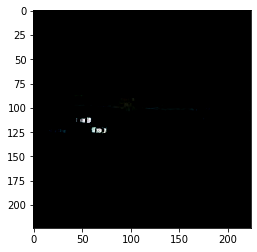

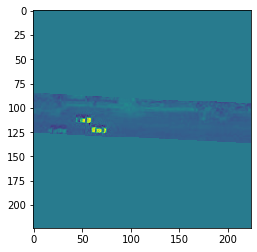

In [17]:
for x, y1 in val_generator:
    plt.imshow(x[0][:, :, 0:3])
    plt.show()
    plt.imshow(x[0][:, :, 1])
    break
    

In [8]:
config["sample"]["size"] * (1 - config["validation_split"]) // config["batch_size"] + 1

29.0

In [7]:
from PIL import Image
import cv2
from tensorflow.keras.applications import resnet_v2 as module
from tensorflow.keras import Sequential, Model, backend
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, ZeroPadding2D, GlobalAveragePooling2D

In [ ]:
convnet.compile(loss=trainer.loss, optimizer=trainer.optimizer, weighted_metrics=config["weighted_metrics"])

# model = convnet.layers[0].layers[-5].output
# model = GlobalAveragePooling2D()(model)
# model = Dense(config["n_classes"], activation="softmax")(model)
# model = Model(inputs=convnet.layers[0].input, outputs=model)

# model.load_weights('data/cls_cropped_normal/checkpoints/weights.01-0.62.hdf5')
# model.load_weights('data/cls_cropped_masked_activate/checkpoints/weights.01-0.68.hdf5')
# model.load_weights('data/cls_cropped_masked-inverted_activate/checkpoints/weights.01-0.68.hdf5')
# convnet.load_weights('data/cls_cropped_masked-overlaid/checkpoints/weights.11-0.85.hdf5')

# model.summary()

# model.compile(loss=trainer.loss, optimizer=trainer.optimizer, weighted_metrics=config["weighted_metrics"])

# model.fit_generator(
#         train_generator, 
#         config["sample"]["size"] * (1 - config["validation_split"]) // config["batch_size"] + 1,
#         epochs=config["n_epochs"],
#         callbacks=trainer.callbacks, 
#         validation_data=val_generator, 
#         validation_steps=config["sample"]["size"] * (config["validation_split"]) // config["batch_size"] + 1,
#         class_weight=data_manager.class_weight("kenya"),
#         use_multiprocessing=True
#     )

# model.add(Dense(config["n_classes"], activation="softmax"))

# convnet.fit_generator(
#     train_generator, 
#     epochs=config["n_epochs"],
#     callbacks=trainer.callbacks, 
#     validation_data=val_generator, 
#     validation_steps=len(val_generator),
#     class_weight=data_manager.class_weight("kenya")
# )

convnet.fit_generator(
        train_generator, 
        config["sample"]["size"] * (1 - config["validation_split"]) // config["batch_size"] + 1,
        epochs=config["n_epochs"],
        callbacks=trainer.callbacks, 
        validation_data=val_generator, 
        validation_steps=config["sample"]["size"] * (config["validation_split"]) // config["batch_size"] + 1,
        class_weight=data_manager.class_weight("kenya")
    )

Epoch 1/15
Found 135000 validated image filenames belonging to 3 classes.
Found 135000 validated image filenames belonging to 3 classes.
 277/4219 [>.............................] - ETA: 2:06:54 - loss: 0.6896 - accuracy: 0.6648

In [9]:
def get_activation_map(image_loaded, image_class):        
      
        if len(image_loaded.shape) < 3:
          image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
        
        preprocessed_image = preprocess_input(image_loaded)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        
#         image_class = np.argmax(image_class_vector)

        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = model.layers[-3]
        
        get_output = backend.function([model.layers[0].input], 
                                               [final_conv_layer.output, model.layers[-1].output])
        
        [conv_outputs, predictions] = get_output(preprocessed_image)
        conv_outputs = conv_outputs[0, :, :, :]

        cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])

        for index, weight in enumerate(class_weights[:, image_class]):
            cam += weight * conv_outputs[:, :, index]
        
        cam /= np.max(cam)
        cam = cv2.resize(cam, (img_size, img_size))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_HOT)
        heatmap[np.where(cam < 0.2)] = 0
        
        img = np.uint8(heatmap * 0.5 + 0.7 * image_loaded)
        return img

Major
Major


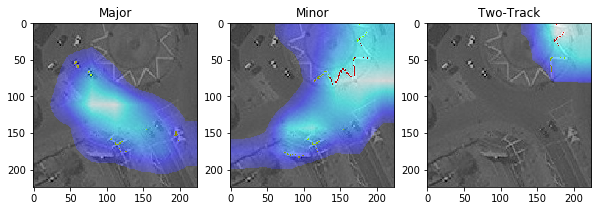

Major


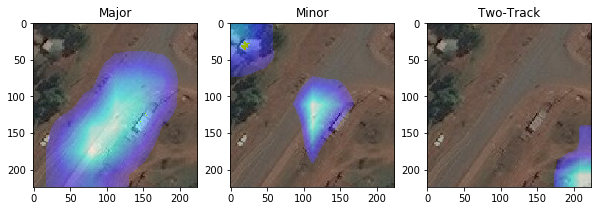

Major


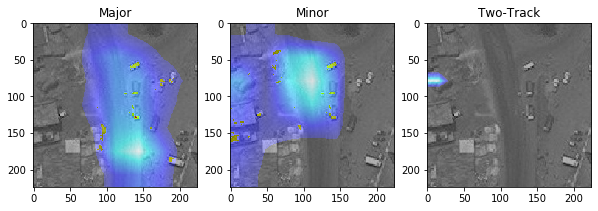

Major


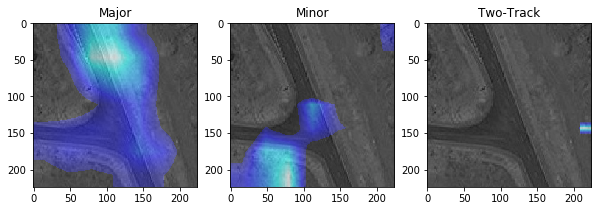

Major


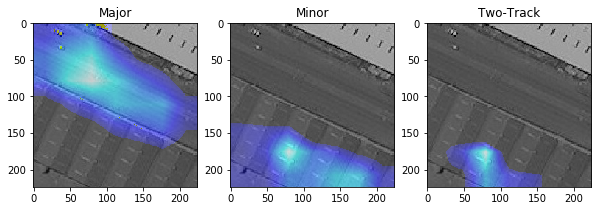

Major


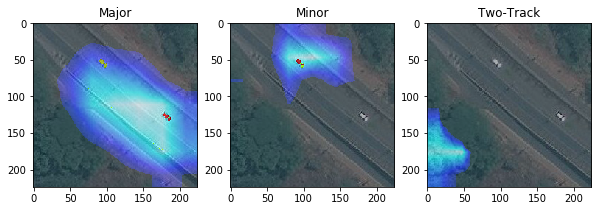

Minor
Two-Track


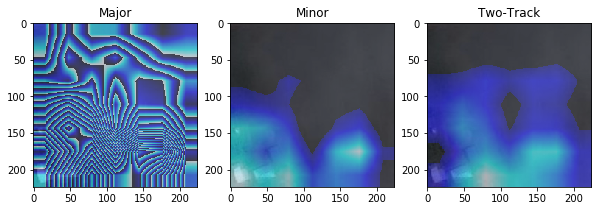

Two-Track


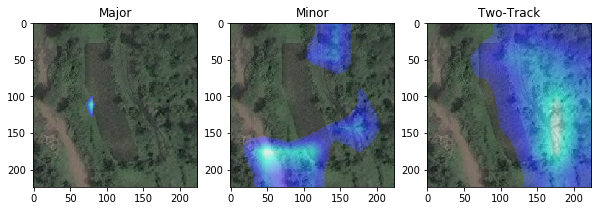

Minor


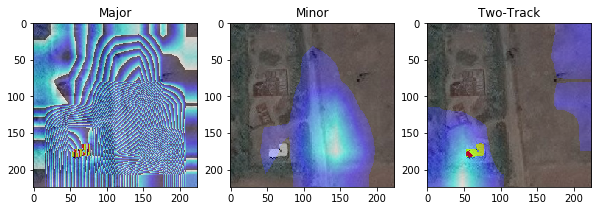

Minor


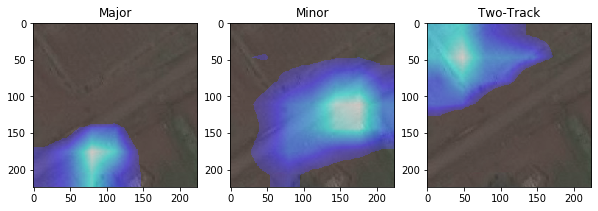

Two-Track


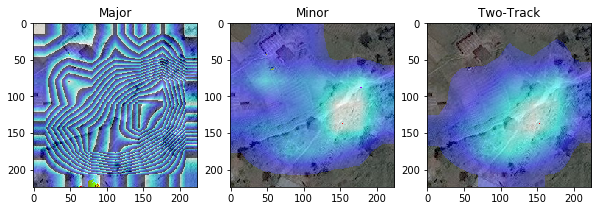

Two Track
Two-Track


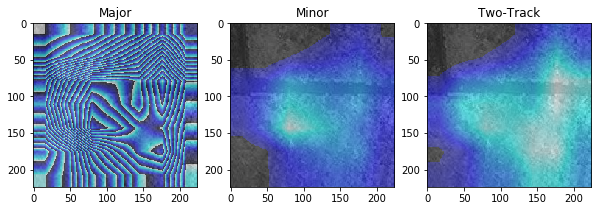

Two-Track


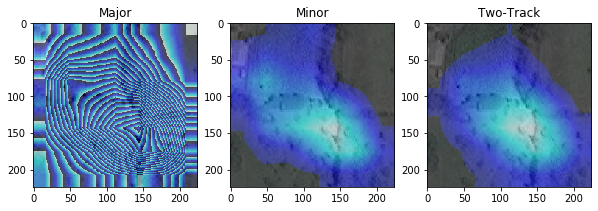

Two-Track


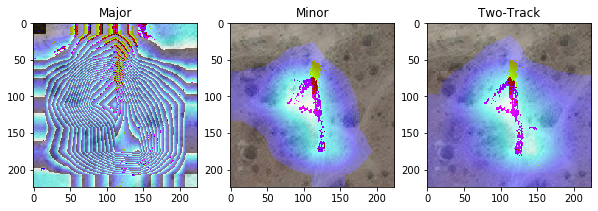

Two-Track


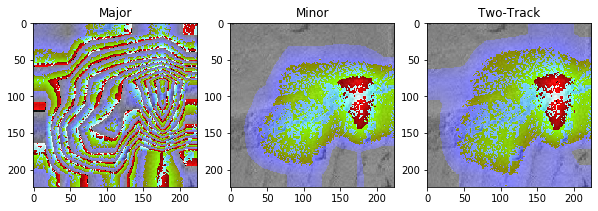

Minor


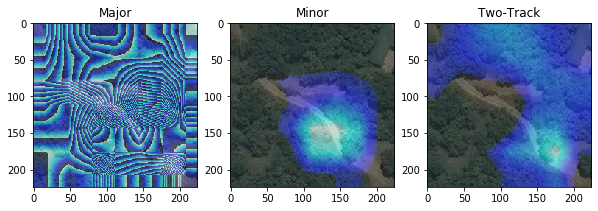

In [14]:
img_size = 224
cropped_path = 'data/kenya/224/cropped/'
mask_path = 'data/kenya/kenya_224x224_masks_20/'

classes = ['Major', 'Minor', 'Two-Track']

# major = dataframe['filename'][dataframe['class'] == 'major'].sample(5, replace=False)
# print(major)
# minor = dataframe['filename'][dataframe['class'] == 'minor'].sample(5, replace=False)
# print(minor)
# two_track = dataframe['filename'][dataframe['class'] == 'two-track'].sample(5, replace=False)
# print(two_track)
major = ['5_115149.jpg', '1123_438147.jpg', '1957_333456.jpg', '2046_369808.jpg', '1871_247723.jpg', '3869_247574.jpg']
minor = ['26864_81079.jpg', '37606_156443.jpg', '63171_371034.jpg', '8594_227439.jpg', '34847_140425.jpg']
two_track = ['130588_109867.jpg', '148741_191167.jpg', '113661_9447.jpg', '170705_480131.jpg', '132457_116487.jpg']

print("Major")

for filename in major:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)

#     image_masked = np.multiply(cropped_image, mask)
#     plt.imshow(image_masked)
#     plt.show()

    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
#     image_masked = np.multiply(preprocessed_image[0], mask)
#     plt.imshow(image_masked)
#     plt.show()
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

print("Minor")
    
for filename in minor:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)    
    
    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

print("Two Track")
    
for filename in two_track:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)
    
    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

Major
Major


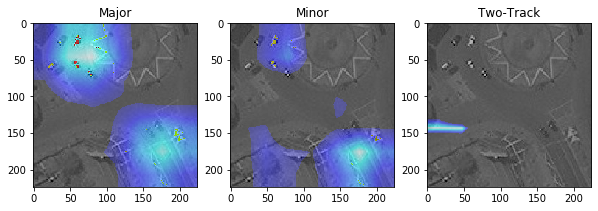

Minor


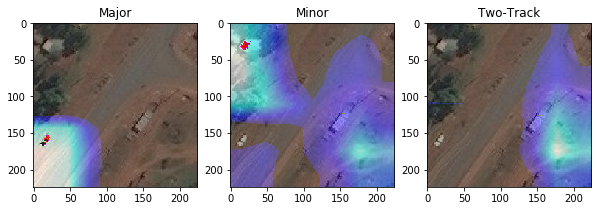

Major


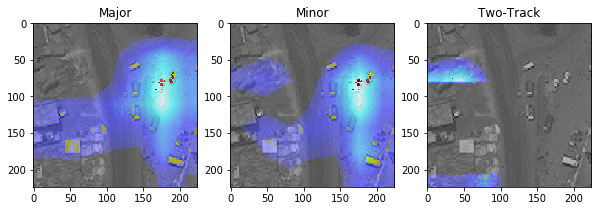

Minor


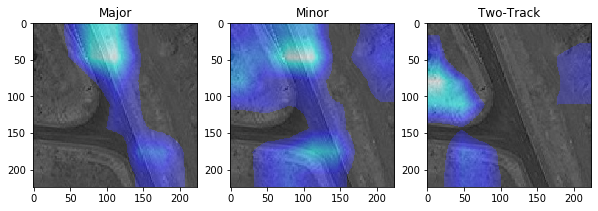

Major


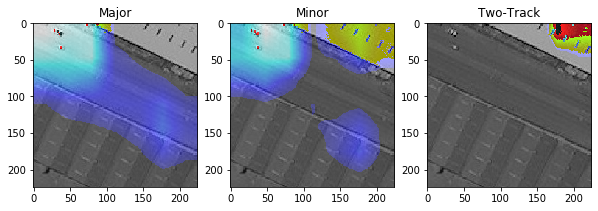

Major


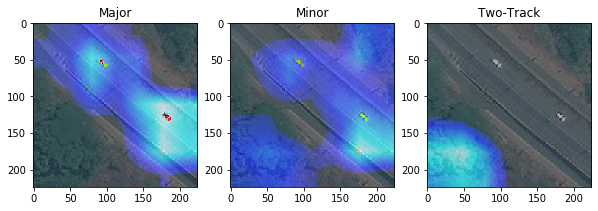

Minor
Minor


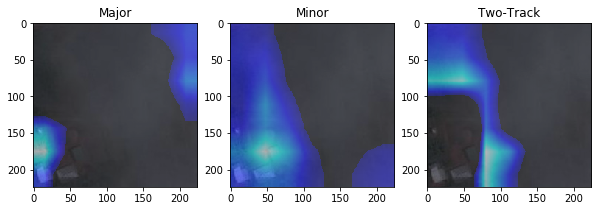

Two-Track


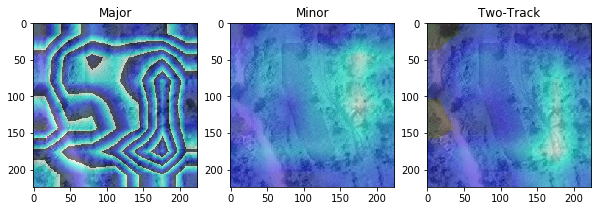

Two-Track


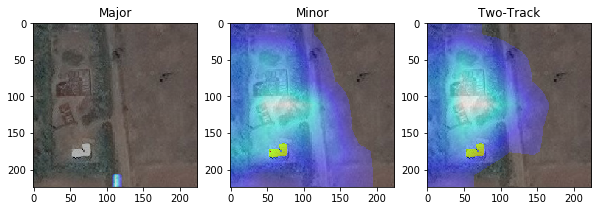

Minor


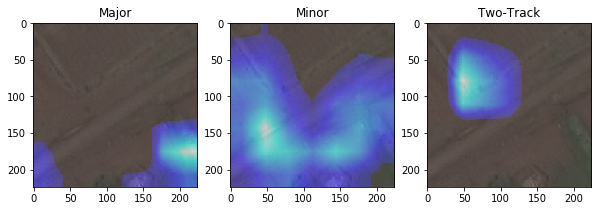

Two-Track


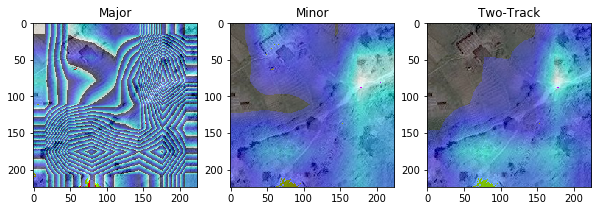

Two Track
Two-Track


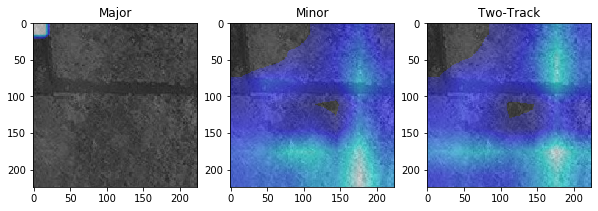

Two-Track


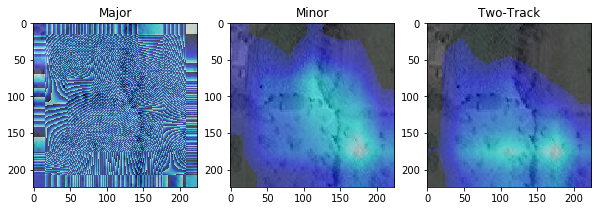

Two-Track


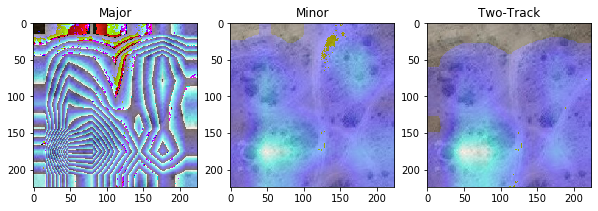

Two-Track


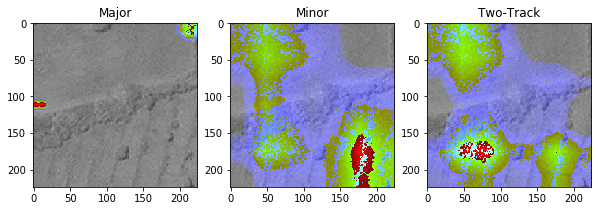

Two-Track


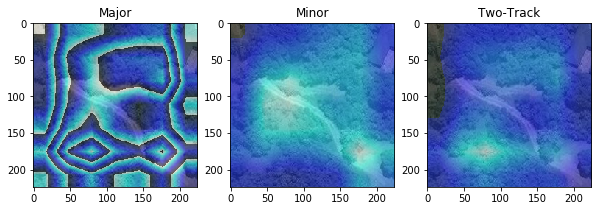

In [16]:
img_size = 224
cropped_path = 'data/kenya/224/cropped/'
mask_path = 'data/kenya/kenya_224x224_masks_20/'

classes = ['Major', 'Minor', 'Two-Track']

# major = dataframe['filename'][dataframe['class'] == 'major'].sample(5, replace=False)
# print(major)
# minor = dataframe['filename'][dataframe['class'] == 'minor'].sample(5, replace=False)
# print(minor)
# two_track = dataframe['filename'][dataframe['class'] == 'two-track'].sample(5, replace=False)
# print(two_track)
major = ['5_115149.jpg', '1123_438147.jpg', '1957_333456.jpg', '2046_369808.jpg', '1871_247723.jpg', '3869_247574.jpg']
minor = ['26864_81079.jpg', '37606_156443.jpg', '63171_371034.jpg', '8594_227439.jpg', '34847_140425.jpg']
two_track = ['130588_109867.jpg', '148741_191167.jpg', '113661_9447.jpg', '170705_480131.jpg', '132457_116487.jpg']

print("Major")

for filename in major:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)

#     image_masked = np.multiply(cropped_image, mask)
#     plt.imshow(image_masked)
#     plt.show()

    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
#     image_masked = np.multiply(preprocessed_image[0], mask)
#     plt.imshow(image_masked)
#     plt.show()
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

print("Minor")
    
for filename in minor:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)    
    
    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

print("Two Track")
    
for filename in two_track:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)
    
    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

Major
Major


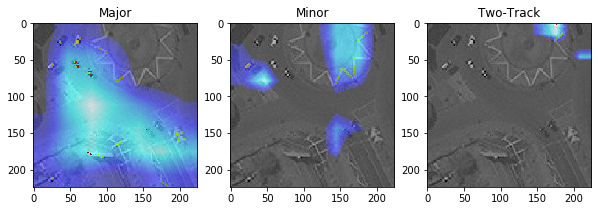

Major


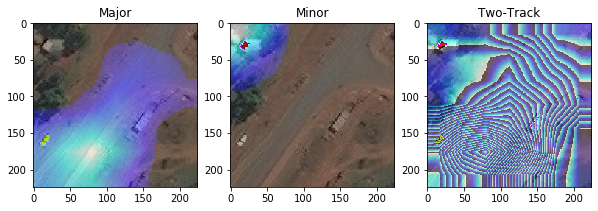

Major


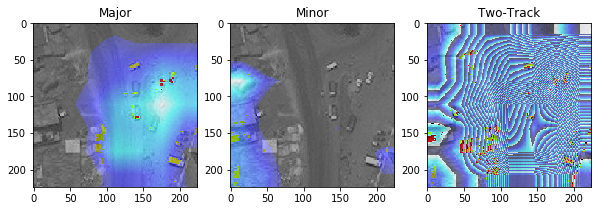

Major


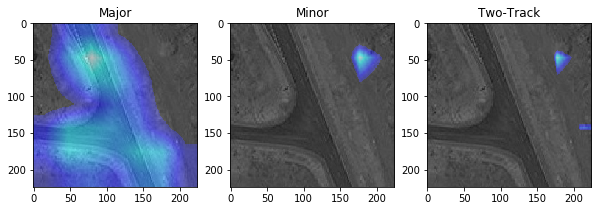

Major


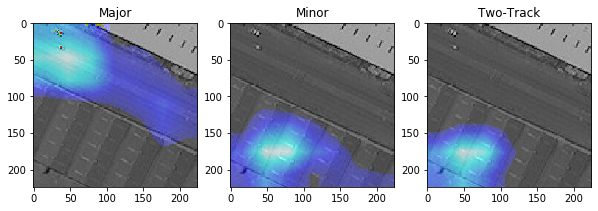

Major


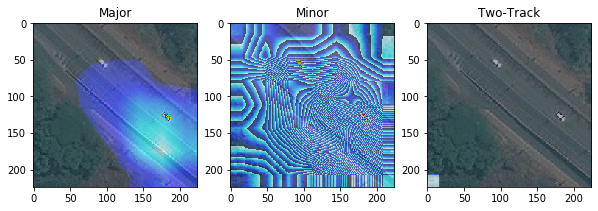

Minor
Two-Track


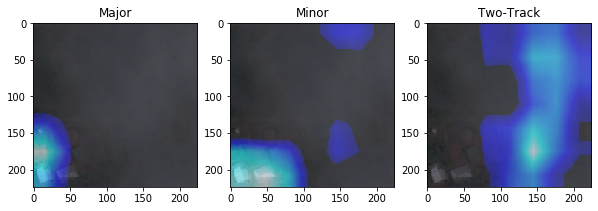

Two-Track


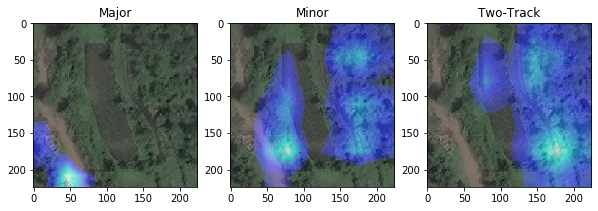

Minor


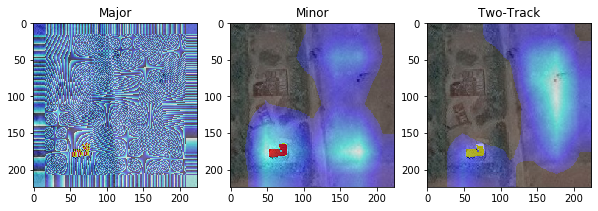

Major


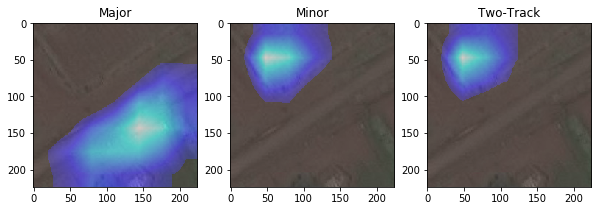

Two-Track


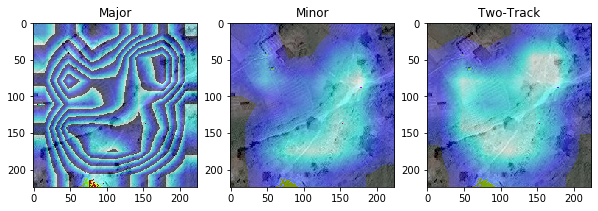

Two Track
Two-Track


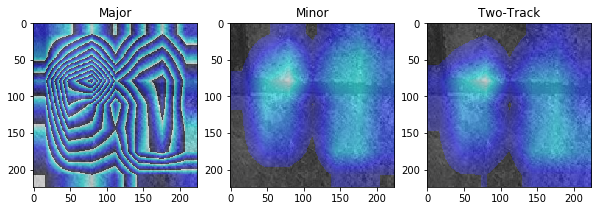

Two-Track


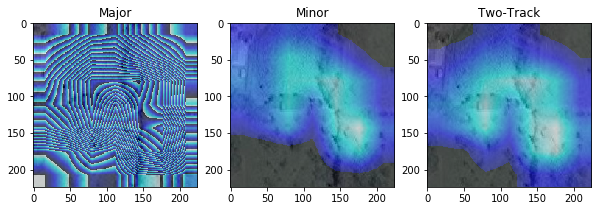

Two-Track


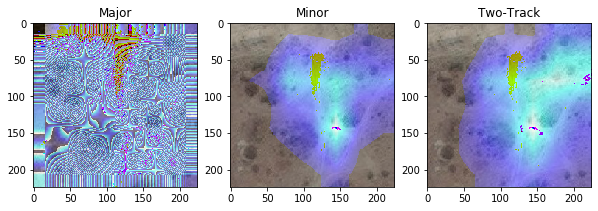

Two-Track


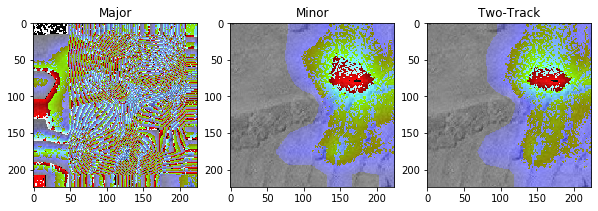

Two-Track


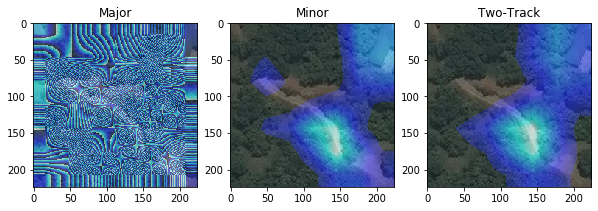

In [11]:
img_size = 224
cropped_path = 'data/kenya/224/cropped/'
mask_path = 'data/kenya/kenya_224x224_masks_20/'

classes = ['Major', 'Minor', 'Two-Track']

# major = dataframe['filename'][dataframe['class'] == 'major'].sample(5, replace=False)
# print(major)
# minor = dataframe['filename'][dataframe['class'] == 'minor'].sample(5, replace=False)
# print(minor)
# two_track = dataframe['filename'][dataframe['class'] == 'two-track'].sample(5, replace=False)
# print(two_track)
major = ['5_115149.jpg', '1123_438147.jpg', '1957_333456.jpg', '2046_369808.jpg', '1871_247723.jpg', '3869_247574.jpg']
minor = ['26864_81079.jpg', '37606_156443.jpg', '63171_371034.jpg', '8594_227439.jpg', '34847_140425.jpg']
two_track = ['130588_109867.jpg', '148741_191167.jpg', '113661_9447.jpg', '170705_480131.jpg', '132457_116487.jpg']

print("Major")

for filename in major:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)

#     image_masked = np.multiply(cropped_image, mask)
#     plt.imshow(image_masked)
#     plt.show()

    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
#     image_masked = np.multiply(preprocessed_image[0], mask)
#     plt.imshow(image_masked)
#     plt.show()
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

print("Minor")
    
for filename in minor:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)    
    
    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

print("Two Track")
    
for filename in two_track:
    cropped_image = Image.open(cropped_path + filename)
    cropped_image = cropped_image.resize((img_size, img_size))
    cropped_image = np.asarray(cropped_image)

    mask = np.flip(cv2.imread('data/kenya/kenya_224x224_masks_20/' + filename.split('_')[0] + '_kenya_224x224_mask_20.png'), axis=0)
    
    preprocessed_image = preprocess_input(cropped_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    print(classes[np.argmax(model.predict(preprocessed_image))])
    
    fig1 = plt.figure(figsize=(10, 30))
    ax1 = []
    num_classes = 3
    for i in range(1, num_classes + 1):
        ax1.append(fig1.add_subplot(1, 3, i))
        ax1[i - 1].title.set_text(classes[i - 1])
        plt.imshow(get_activation_map(cropped_image, i - 1))
    plt.show()

In [53]:
pretrained_type = config["pretrained"]["type"]
ConvNet = getattr(module, pretrained_type)

input_layer = Input(shape=(224, 224, 3))
multichannel_concat_layer = Conv2D(filters=3, kernel_size=3, padding='same')(input_layer)

convnet = ConvNet(
    include_top=False,
    input_tensor=input_layer,
    weights='imagenet',
    pooling=config["pretrained"]["pooling"],
    classes=config["n_classes"]
)

convnet.summary()

# if config["pretrained"]["frozen"]:
#         for layer in convnet.layers:
#             layer.trainable = False

# model = Sequential(convnet)
# model.add(Flatten())
# for layer in range(config["pretrained"]["fnn_layers"]):
#     model.add(Dense(config["pretrained"]["fnn_units"], activation="relu"))
#     model.add(Dropout(config["pretrained"]["dropout"]))
# model.add(Dense(config["n_classes"], activation="softmax"))

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


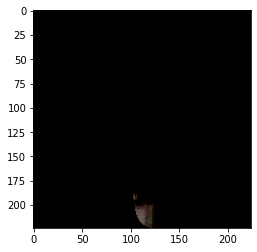

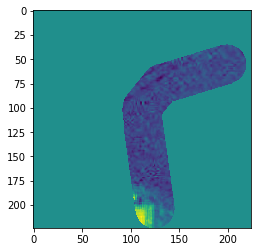

In [18]:
for x, y1 in val_generator:
    plt.imshow(x[0][:, :, 0:3])
    plt.show()
    plt.imshow(x[0][:, :, 1])
    break
    

[2 0 0 2 2 2 2 2 2 1 1 0 2 0 2 2 1 0 2 1 1 1 0 2 0 2 2 2 2 2 2 2]
[2 0 1 2 2 2 2 2 2 1 2 0 2 0 2 2 2 0 2 2 1 1 0 2 1 2 2 1 2 1 2 2]
[2 2 1 1 0 1 2 0 1 0 1 0 2 1 0 0 2 1 0 0 1 1 2 2 0 0 1 1 0 1 2 1]
[1 2 1 2 0 1 1 0 1 0 1 0 2 1 0 0 2 1 0 0 0 2 2 2 1 0 1 1 0 1 2 1]
[1 0 1 1 0 0 0 0 0 0 0 0 2 1 1 2 1 0 1 1 0 0 1 1 1 1 0 2 0 0 1 1]
[1 0 1 1 0 0 0 0 0 0 0 2 2 1 1 2 1 0 1 1 0 0 1 1 1 2 0 1 0 0 1 2]
[1 0 2 2 1 1 0 0 1 0 1 0 1 1 2 2 0 0 1 1 1 2 1 0 2 2 1 1 0 2 2 2]
[1 0 2 2 1 2 2 2 2 1 1 0 1 1 2 2 0 0 1 1 1 2 2 1 2 1 2 1 0 2 2 1]
[2 0 1 1 1 1 0 2 2 0 2 2 0 2 0 1 0 1 1 2 1 2 2 2 2 2 2 1 2 1 2 2]
[1 0 1 1 2 1 0 2 2 1 2 2 0 2 0 1 0 1 2 2 1 2 2 1 2 2 1 1 2 2 2 2]
[0 1 2 0 2 0 1 1 1 1 1 2 1 0 2 2 0 1 0 2 1 0 0 1 0 2 0 0 2 0 2 0]
[0 2 2 0 2 0 1 2 2 1 1 2 2 0 2 2 0 2 0 2 1 0 0 1 0 2 0 0 2 0 2 0]
[1 2 2 2 2 0 0 1 0 2 0 2 1 1 0 2 1 0 1 0 1 0 1 1 2 0 0 2 2 2 0 2]
[1 2 2 2 1 0 0 0 0 2 1 2 1 1 0 2 1 0 0 0 0 1 1 1 2 0 0 2 2 1 0 2]
[0 2 1 2 2 1 0 0 2 0 1 0 0 2 1 2 1 1 2 2 1 1 1 0 2 2 0 2 2 0 1 0]
[1 2 1 2 2

(2.5, -0.5)

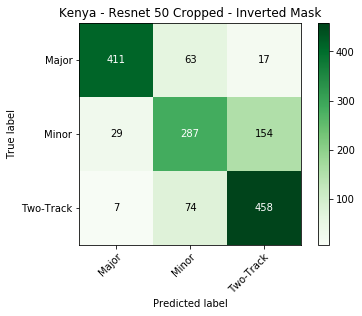

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = np.array([])
y_pred = np.array([])
k = 0;

# model=convnet # CAREFUL WITH THIS LINE

for i, x1 in val_generator:
#     plt.imshow(i[0])
#     plt.show()
    y_true = np.concatenate((y_true, np.argmax(x1, axis=1)))
    print(np.argmax(x1, axis=1))
    print(np.argmax(model.predict(i), axis=1))
    y_pred = np.concatenate((y_pred, np.argmax(model.predict(i), axis=1)))
    k += 1
    if k == 47:
        print(k)
        break

# y_true = val_generator.classes
# y_pred = np.argmax(predictions, axis=1)

print(np.sum(y_true==y_pred))

classes = ['Major', 'Minor', 'Two-Track']

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Kenya - Resnet 50 Cropped - Inverted Mask',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.show()
plt.ylim([2.5, -0.5])

In [ ]:
print('butt')

In [63]:
model_config = convnet.get_config()
# print(model_config)
model = Sequential()
model.add(input_layer)
model.add(ZeroPadding2D(3))
model.add(Conv2D(filters=64, kernel_size = 7, strides=(2, 2), padding='valid'))
for layer in convnet.layers[3:10]:
    print(layer.name)
    model.add(layer)

model.summary()

pool1_pad
pool1_pool
conv2_block1_preact_bn
conv2_block1_preact_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
pool1_pad (ZeroPadding2D)    multiple                  0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    multiple                  0         
_________________________________________________________________
conv2_block1_preact_bn (Batc multiple                  256       
_________________________________________________________________
conv2_block1_preact_relu (Ac multiple                  0  